# Demographics for Transit Oriented Communities entitlements

Let's take a close look at entitlement applications for Transit Oriented Communities (TOC).

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.inspection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils
import xlsxwriter

import laplan
import utils

cat = intake.open_catalog("../catalogs/*.yml")

First, we load a bunch of relevant data.

In [2]:
# Census tracts
tracts = cat.census_tracts.read().set_index("GEOID")

# Crosswalk from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

# Zoning
eligible_zones = ['R2', 'R3', 'RAS3', 'R4', 'RAS4', 'R5', 
                  'RD1.5', 'RD2', 'RD3', 'RD4', 'RD5', 'RD6', 
                  'C1', 'C2', 'C4', 'C5']

favorable_zones = ['R3', 'R4', 'C2']

zoning = (cat.crosswalk_tracts_zone_class.read()
          [["GEOID"] + eligible_zones]
         )

zoning = (zoning.assign(
            pct_eligible_zoning = zoning[eligible_zones].sum(axis=1).fillna(0), 
            pct_favorable_toc_zoning = zoning[favorable_zones].sum(axis=1).fillna(0),
          ).drop(columns = eligible_zones)
          .set_index("GEOID")
         )

In [3]:
joined = utils.entitlements_per_tract(
    suffix_list=["TOC"],
    verbose=True,
    aggregate_years=True,
).fillna({"TOC": 0})

Loading PCTS
Parsing PCTS case numbers
6 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'TT', 'APCSV', 'VTT', 'PS', 'HPO', 'APCS', 'APCE', 'ENV', 'CPC', 'CHC', 'APCH', 'APCNV', 'AA', 'APCW'}
Loading census analysis table
Removing cases touching more than 20 parcels
Aggregating entitlements to tract
Joining entitlements to census data


One of our primary variables for TOC entitlements is how many parcels are eligible.
Let's count the number of eligible parcels in each tier on a per-census-tract basis:

In [4]:
tier_parcels = (
    parcel_to_tract
    [parcel_to_tract.TOC_Tier > 0]
    .groupby(["GEOID", "TOC_Tier"])
    .size()
    .to_frame("n")
    .reset_index(level=1)
    .pivot(columns="TOC_Tier", values="n")
    .rename(columns=lambda x: f"Tier_{x}")
    .fillna(0.0)
    .astype(int)
)
tier_parcels

TOC_Tier,Tier_1,Tier_2,Tier_3,Tier_4
GEOID,,,,
06037104320,371,24,0,0
06037104401,166,0,0,0
06037104404,229,31,0,0
06037104610,407,29,0,0
06037104620,230,0,0,0
...,...,...,...,...
06037703100,194,26,0,0
06037703200,24,0,230,52
06037980009,3,0,0,0


Get all of the tracts for which more than 50% of the parcels fall within one TOC tier.
Consider those tracts to be TOC tracts.

In [5]:
toc_eligible_tracts = (parcel_to_tract[["GEOID", "total_AIN", "pct_toc_AIN", "toc_AIN"]]
                       .drop_duplicates()
                        .assign(
                           toc_AIN = parcel_to_tract.toc_AIN.astype(bool)
                       )
                       .set_index("GEOID")
                      )

toc_eligible_tracts.head()

,total_AIN,pct_toc_AIN,toc_AIN
GEOID,,,
06037101110,1274,0.0,False
06037101122,1475,0.0,False
06037101210,629,0.0,False
06037101220,814,0.0,False
06037101300,2022,0.0,False


Plot up the TOC-eligible tracts:

<AxesSubplot:>

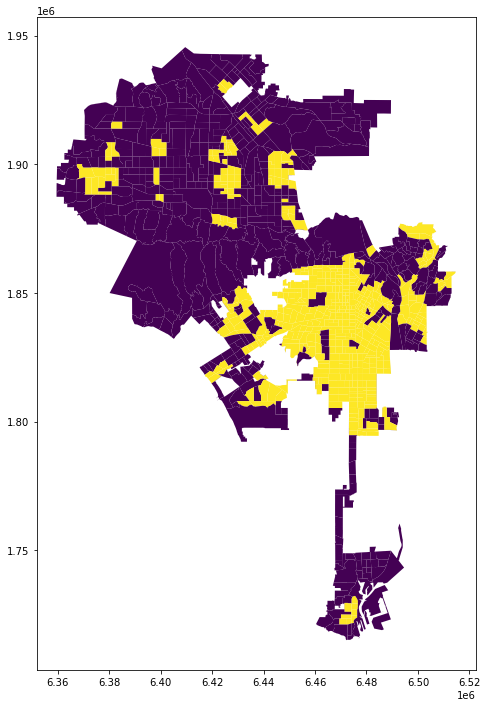

In [6]:
tracts.merge(toc_eligible_tracts, 
             left_index=True, 
             right_index=True,
            ).plot(column="toc_AIN", figsize = (12, 12))

Let's count the number of TOC entitlements per tract:

In [7]:
joined = (pandas.merge(
        joined, 
        tier_parcels, 
        how="left", 
        left_index=True, 
        right_index=True,
    ).merge(
        toc_eligible_tracts, 
        how="left", 
        left_index=True,
        right_index=True,
    ).merge(
        zoning, 
        how="left", 
        left_index=True,
        right_index=True,
    ).fillna(0)
    .dropna()
    .rename(columns = {"toc_AIN": "TOC_eligible"})
)

In [8]:
joined = (geopandas.GeoDataFrame(
    joined, 
    geometry=tracts.geometry)
    .assign(
        eligible_zoning = (joined.total_AIN * joined.pct_eligible_zoning).round(0),
        favorable_toc_zoning = (joined.total_AIN * joined.pct_favorable_toc_zoning).round(0)
    )
)

## Demographics of TOC tracts

Let's investigate the demographic differences between TOC tracts and non-toc tracts.

In order to do so in a population-normalized way, we have to use population totals rather than percentages.

In [9]:
non_toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[False]
toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[True]
income_cols = [c for c in joined.columns if c.startswith("total_")]
demo_cols = [
    "non_car_workers",
    "zero_veh_workers",
    "pop_renter",
    "pop_whitenonhisp",
]
other_cols = [
    "eligible_zoning", 
    "favorable_toc_zoning", 
    "Tier_1", 
    "Tier_2", 
    "Tier_3", 
    "Tier_4", 
]
toc_pop_totals = joined.groupby("TOC_eligible")[[
    "pop_total",
    *demo_cols,
    *income_cols,
    *other_cols,
]].sum().astype("float")

In [10]:
toc_pop_totals.loc[False, demo_cols] = (
    toc_pop_totals.loc[False, demo_cols] / 
    toc_pop_totals.loc[False, "pop_total"]
)
toc_pop_totals.loc[True, demo_cols] = (
    toc_pop_totals.loc[True, demo_cols] / 
    toc_pop_totals.loc[True, "pop_total"]
)

In [11]:
toc_pop_totals.loc[False, other_cols] = (
    toc_pop_totals.loc[False, other_cols] / 
    toc_pop_totals.loc[False, "total_AIN"]
)

toc_pop_totals.loc[True, other_cols] = (
    toc_pop_totals.loc[True, other_cols] / 
    toc_pop_totals.loc[True, "total_AIN"]
)

In [12]:
toc_pop_totals.loc[False, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[False],
        [50],
    )[0]
)
toc_pop_totals.loc[True, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[True],
        [50],
    )[0]
)

In [13]:
toc_pop_totals[demo_cols + ["medhhincome"] + other_cols].T.style.format("{:.2n}")

TOC_eligible,False,True
non_car_workers,0.042,0.095
zero_veh_workers,0.016,0.046
pop_renter,0.48,0.73
pop_whitenonhisp,0.38,0.2
medhhincome,74,47
eligible_zoning,0.1,0.57
favorable_toc_zoning,0.041,0.22
Tier_1,0.039,0.36
Tier_2,0.0055,0.19
Tier_3,0.018,0.27


In [14]:
# Export table in Excel
writer = pandas.ExcelWriter('../outputs/toc-regression.xlsx', engine='xlsxwriter')

toc_pop_totals[demo_cols + ["medhhincome"] + other_cols].T.to_excel(writer, sheet_name = 'toc_descriptives')

writer.save()

## Modeling TOC entitlements

Let's use a Random Forest regressor as a baseline model for relating TOC permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [15]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "Tier_1",
    "Tier_2",
    "Tier_3",
    "Tier_4",
    "pct_eligible_zoning", 
    "pct_favorable_toc_zoning",
]
target = "TOC"

In [16]:
to_fit = joined.dropna()[variables + [target, "total_AIN", "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

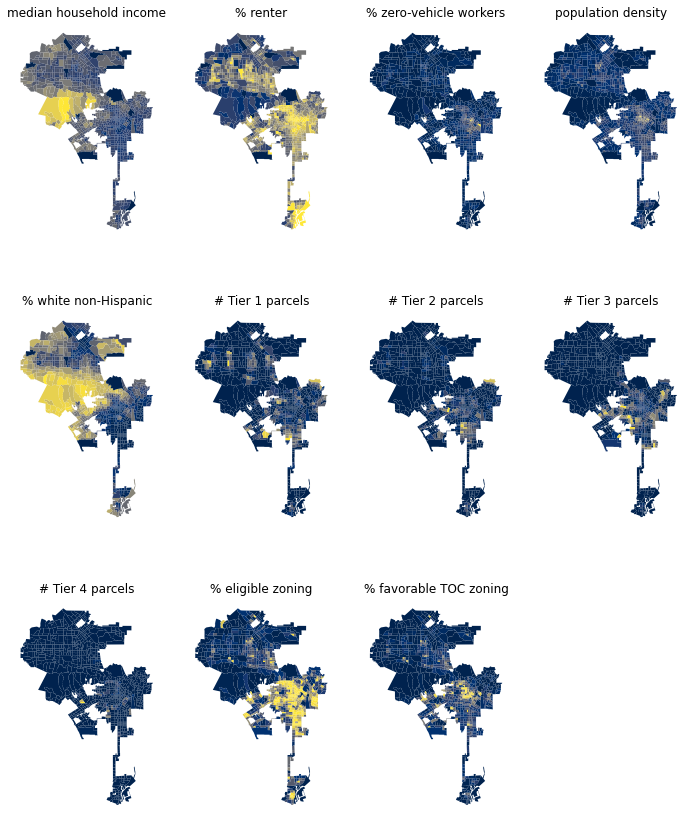

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(12,15))

predictor_titles = {
    "medhhincome": "median household income",
    "pct_pop_renter": "% renter",
    "pct_zero_veh_workers": "% zero-vehicle workers",
    "density": "population density",
    "pct_whitenonhisp": "% white non-Hispanic",
    "Tier_1": "# Tier 1 parcels",
    "Tier_2": "# Tier 2 parcels",
    "Tier_3": "# Tier 3 parcels",
    "Tier_4": "# Tier 4 parcels",
    "pct_eligible_zoning": "% eligible zoning",
    "pct_favorable_toc_zoning": "% favorable TOC zoning",
}

for i, var in enumerate(variables):   
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var, cmap="cividis")
    ax.axis("off")
    ax.set_title(predictor_titles[var])
    

# Delete the 12th one because it's empty
fig.delaxes(axes[2][3])

fig.savefig("../visualization/toc_regression_predictors_map.png", bbox_inches='tight')

# How to add shared colorbar
# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar

Filter to only fit counts in tracts that have *some* eligible parcels:

In [18]:
to_fit = to_fit[
    (to_fit.Tier_1 > 0) |
    (to_fit.Tier_2 > 0) |
    (to_fit.Tier_3 > 0) |
    (to_fit.Tier_4 > 0)
]

In [19]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=10)),
])

In [20]:
def plot_model(predictions):
    vmin=0
    vmax=0.15
    cmap="inferno"
    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual TOC/parcel")
    (tracts
     .assign(
         TOC=to_fit.TOC,
         norm_TOC=to_fit.TOC.divide(to_fit.total_AIN),
     ).fillna({"TOC": 0, "norm_TOC": 0})
     .plot(ax=axes[0],column="norm_TOC", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted TOC/parcel")
    (tracts
     .assign(
         predictions=pandas.Series(predictions, index=to_fit.index),
         norm_pred=pandas.Series(predictions, index=to_fit.index).divide(to_fit.total_AIN),
     )
     .fillna({"predictions": 0, "norm_pred": 0})
     .plot(ax=axes[1],column="norm_pred", cmap=cmap, vmin=vmin, vmax=vmax)
    )
    plt.close(fig)
    return fig

Plot up the model to see how it does:

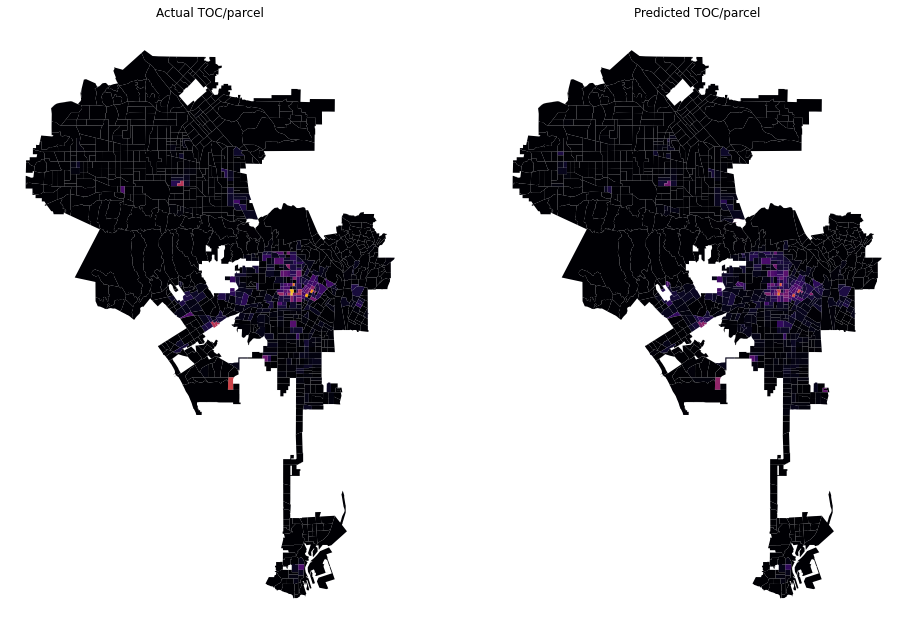

In [21]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])

rf_plot = plot_model(random_forest_model.predict(to_fit[variables]))

rf_plot.savefig("../visualization/toc_regression_actual_predicted_randomforest_all.png", bbox_inches='tight')
rf_plot

In [22]:
print(f"Score: {random_forest_model.score(to_fit[variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=variables,
).sort_values(ascending=False)

Score: 0.8727195735332047


pct_favorable_toc_zoning    0.324363
Tier_2                      0.137294
Tier_3                      0.134571
pct_pop_renter              0.074533
pct_zero_veh_workers        0.057386
pct_eligible_zoning         0.054022
medhhincome                 0.052795
pct_whitenonhisp            0.051502
density                     0.048920
Tier_1                      0.042620
Tier_4                      0.021995
dtype: float64

In [23]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=variables)

medhhincome                 0.054486
pct_pop_renter              0.107643
pct_zero_veh_workers        0.072390
density                     0.044569
pct_whitenonhisp            0.056987
Tier_1                      0.069896
Tier_2                      0.324424
Tier_3                      0.409482
Tier_4                      0.036737
pct_eligible_zoning         0.061694
pct_favorable_toc_zoning    1.038712
dtype: float64

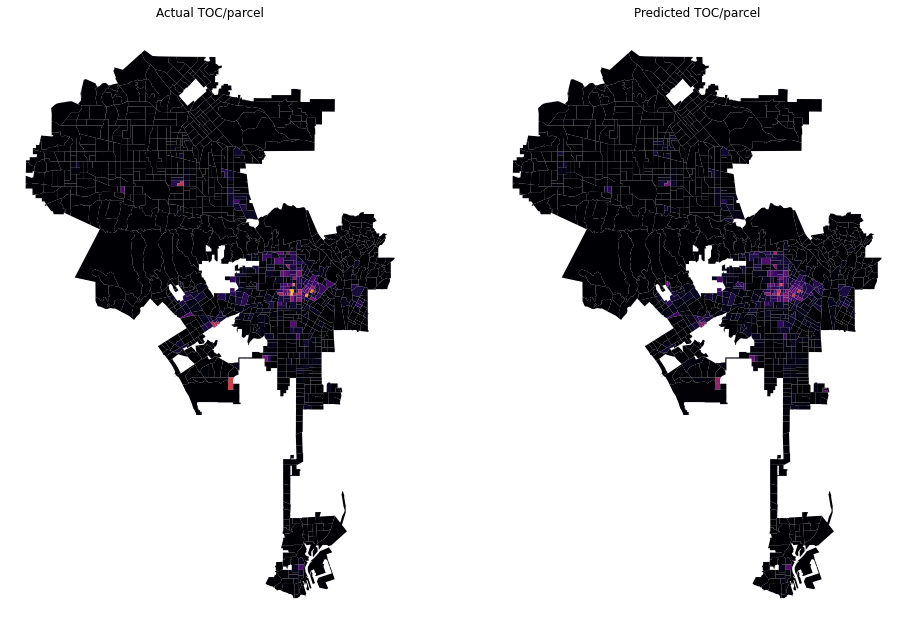

In [24]:
np.random.seed(1)
fewer_variables = [
    "pct_favorable_toc_zoning",
    "Tier_3",
    "Tier_2",
    "pct_pop_renter",
]

random_forest_model.fit(to_fit[fewer_variables], to_fit[target])
rf_plot_fewer = plot_model(random_forest_model.predict(to_fit[fewer_variables]))

rf_plot_fewer.savefig("../visualization/toc_regression_actual_predicted_randomforest_fewer.png", bbox_inches='tight')
rf_plot_fewer

In [25]:
print(f"Score: {random_forest_model.score(to_fit[fewer_variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=fewer_variables
).sort_values(ascending=False)

Score: 0.8626593732679138


pct_favorable_toc_zoning    0.421830
Tier_3                      0.221556
Tier_2                      0.201515
pct_pop_renter              0.155098
dtype: float64

In [26]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[fewer_variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

pct_favorable_toc_zoning    0.990344
Tier_3                      0.507841
Tier_2                      0.457021
pct_pop_renter              0.237742
dtype: float64

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of TOC entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [27]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, alpha=0, tol=1.e-6))
])

In [28]:
def sample_poisson_model(data, target, norm=1, seed=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    rs = np.random.RandomState(seed)
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                    random_state=rs,
                )
            )
        )
        for i in range(1000)
    ])
    return samples

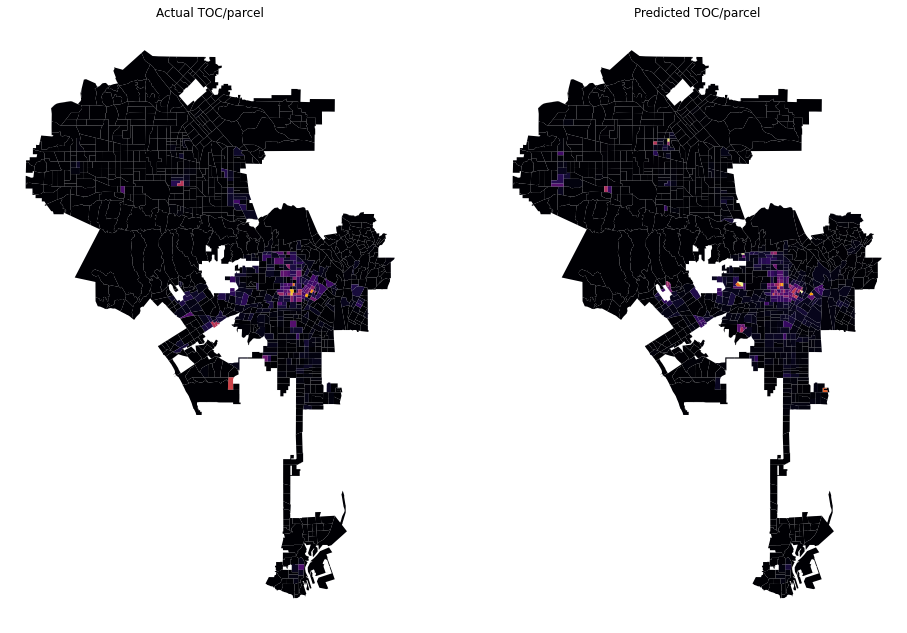

In [29]:
poisson_model.fit(to_fit[fewer_variables], to_fit[target])

poisson_plot = plot_model(poisson_model.predict(to_fit[fewer_variables]))

poisson_plot.savefig("../visualization/toc_regression_actual_predicted_poisson_fewer.png", bbox_inches='tight')
poisson_plot

In [30]:
print(f"Poisson Score: {poisson_model.score(to_fit[fewer_variables], to_fit[target].astype('int64'))}")

Poisson Score: 0.3724541370223473


In [31]:
imp = sklearn.inspection.permutation_importance(
    poisson_model,
    to_fit[fewer_variables],
    to_fit[target].astype("int64")
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

pct_favorable_toc_zoning    0.273730
Tier_3                      0.234401
Tier_2                      0.167505
pct_pop_renter              0.128201
dtype: float64

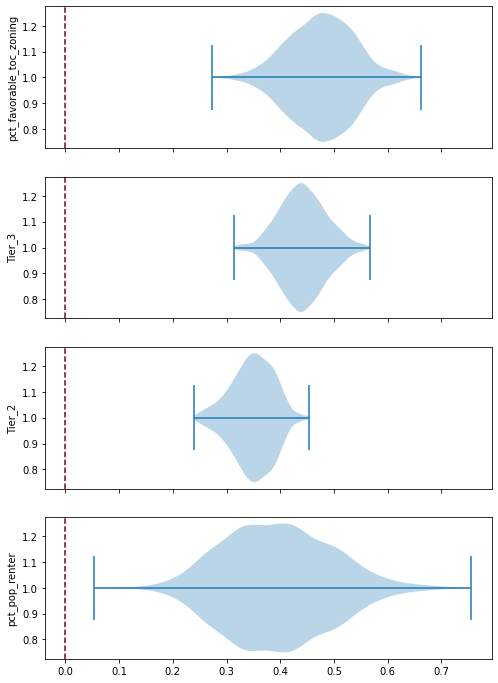

In [32]:
subset = fewer_variables
samples = sample_poisson_model(to_fit[subset], to_fit[target])

fig, axes = plt.subplots(
    len(subset),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,12),

)

for i, var in enumerate(subset):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

#### Interpreting the coefficients

In [33]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [34]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=fewer_variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [35]:
import IPython.display

In [36]:
scale = 0.1
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in favorable TOC (R2, R3, C2) zoning, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 100
val = (np.exp(beta[1]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 3 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 100
val = (np.exp(beta[2]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 2 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 0.1
val = (np.exp(beta[3]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of renters, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))

For every 10% increase in favorable TOC (R2, R3, C2) zoning, there is a 23% increase in TOC entitlements

For every 100 Tier 3 parcels, there is a 33% increase in TOC entitlements

For every 100 Tier 2 parcels, there is a 36% increase in TOC entitlements

For every 10% increase in population of renters, there is a 8% increase in TOC entitlements